# Libraries

In [2]:
import os
import sys
sys.path.append('/home/kurose/Desktop/master/viu_master_thesis')

import importlib
import models.model_utils

importlib.reload(models.model_utils)
from models.model_utils import load_dataset, get_input_shape, f1_score, get_callbacks, save_and_print_model, get_metrics, plot_metrics

import tensorflow as tf

tf.random.set_seed(42)

# Model 3

## Dataset 

In [3]:

train, val, _ = load_dataset(batch_size=2)

## Architecture

In [4]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))

def extract_2d_features_batched(volume_batch):

    extracted_features = []

    for i in range(volume_batch.shape[1]): 
        slice_img = volume_batch[:, i, :, :, :]  # Extract the i-th slice from the batch
        
        # Repeat grayscale channel to simulate 3 channels for the pre-trained model (for each slice)
        slice_img = tf.repeat(slice_img, repeats=3, axis=-1)
        
        # Apply the pre-trained 2D model to the slice
        features = base_model(slice_img)
        extracted_features.append(features)

    # Stack the extracted features along the depth (z-axis) to form a 3D volume of features
    stacked_features = tf.stack(extracted_features, axis=1)
    
    return stacked_features

In [5]:
def model_v3(input_shape):
    volume_input = tf.keras.Input(shape=(input_shape))  
    
    features = tf.keras.layers.Lambda(extract_2d_features_batched, output_shape=(33, 4, 4, 2048))(volume_input)

    # First Block: 3D Convolution + BatchNormalization + ReLU + MaxPooling
    x = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same')(features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Global Average Pooling 3D instead of Flatten
    x = tf.keras.layers.GlobalAveragePooling3D()(x)

    # Fully connected layer (Dense layer) + Dropout
    x = tf.keras.layers.Dense(units=16, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x) 

    # Output layer
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
    
    # Define the model
    model = tf.keras.Model(inputs=volume_input, outputs=outputs)

    return model

In [6]:
input_shape = get_input_shape(train)
model = model_v3(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=get_metrics())

In [7]:
save_and_print_model(model, file_path="model_v3.png")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 33, 4, 4, 2048) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 33, 4, 4, 32)   │     1,769,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 33, 4, 4, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 33, 4, 4, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 2, 2, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 2, 2, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,770,177 (6.75 MB)

 Trainable params: 1,770,113 (6.75 MB)

 Non-trainable params: 64 (256.00 B)

Model architecture saved to model_v3.png


# Training

In [8]:
callbacks = get_callbacks(
    checkpoint_path='best_model_v3.weights.h5',
    monitor_metric='val_accuracy',
    patience=5,
    reduce_factor=0.1,
    reduce_patience=2,
    reduce_min_lr=1e-6)
              
history = model.fit(train, validation_data=val, epochs=25, callbacks=callbacks)

Epoch 1/25


      8/Unknown 391s 4s/step - accuracy: 0.6397 - auc: 0.4759 - f1_score: 0.4042 - loss: 0.7426

2024-10-08 23:32:59.693940: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-08 23:34:09.660459: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 466s 14s/step - accuracy: 0.6381 - auc: 0.4838 - f1_score: 0.3922 - loss: 0.7429 - val_accuracy: 0.2500 - val_auc: 0.0000e+00 - val_f1_score: 0.2222 - val_loss: 1.3951 - learning_rate: 1.0000e-04
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5761 - auc: 0.8552 - f1_score: 0.2911 - loss: 0.6708

2024-10-08 23:34:52.056518: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.5746 - auc: 0.8400 - f1_score: 0.2958 - loss: 0.6752 - val_accuracy: 0.2500 - val_auc: 0.2500 - val_f1_score: 0.0000e+00 - val_loss: 1.2960 - learning_rate: 1.0000e-04
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5978 - auc: 0.3853 - f1_score: 0.4332 - loss: 0.7723 - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 1.3953 - learning_rate: 1.0000e-04
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5874 - auc: 0.7235 - f1_score: 0.3065 - loss: 0.5639

2024-10-08 23:36:11.238034: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5708 - auc: 0.7030 - f1_score: 0.2992 - loss: 0.5832 - val_accuracy: 0.2500 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 1.2785 - learning_rate: 1.0000e-04
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7451 - auc: 0.8717 - f1_score: 0.3614 - loss: 0.5208 - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - val_f1_score: 0.3333 - val_loss: 1.5740 - learning_rate: 1.0000e-04
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6234 - auc: 0.8634 - f1_score: 0.3463 - loss: 0.6030 - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - val_f1_score: 0.3333 - val_loss: 1.3818 - learning_rate: 1.0000e-05
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.7099 - auc: 0.8305 - f1_score: 0.4327 - loss: 0.4643 - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - val_f1_score: 0.3333 - val_loss: 1.4067 - learning_rate: 1.0000e-05
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9833 - auc: 1.0000 - f1_sc

2024-10-08 23:38:48.720220: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9782 - auc: 1.0000 - f1_score: 0.3362 - loss: 0.2751 - val_accuracy: 0.5000 - val_auc: 0.0000e+00 - val_f1_score: 0.3333 - val_loss: 1.2979 - learning_rate: 1.0000e-06


Plot saved to model_v3_metrics.png


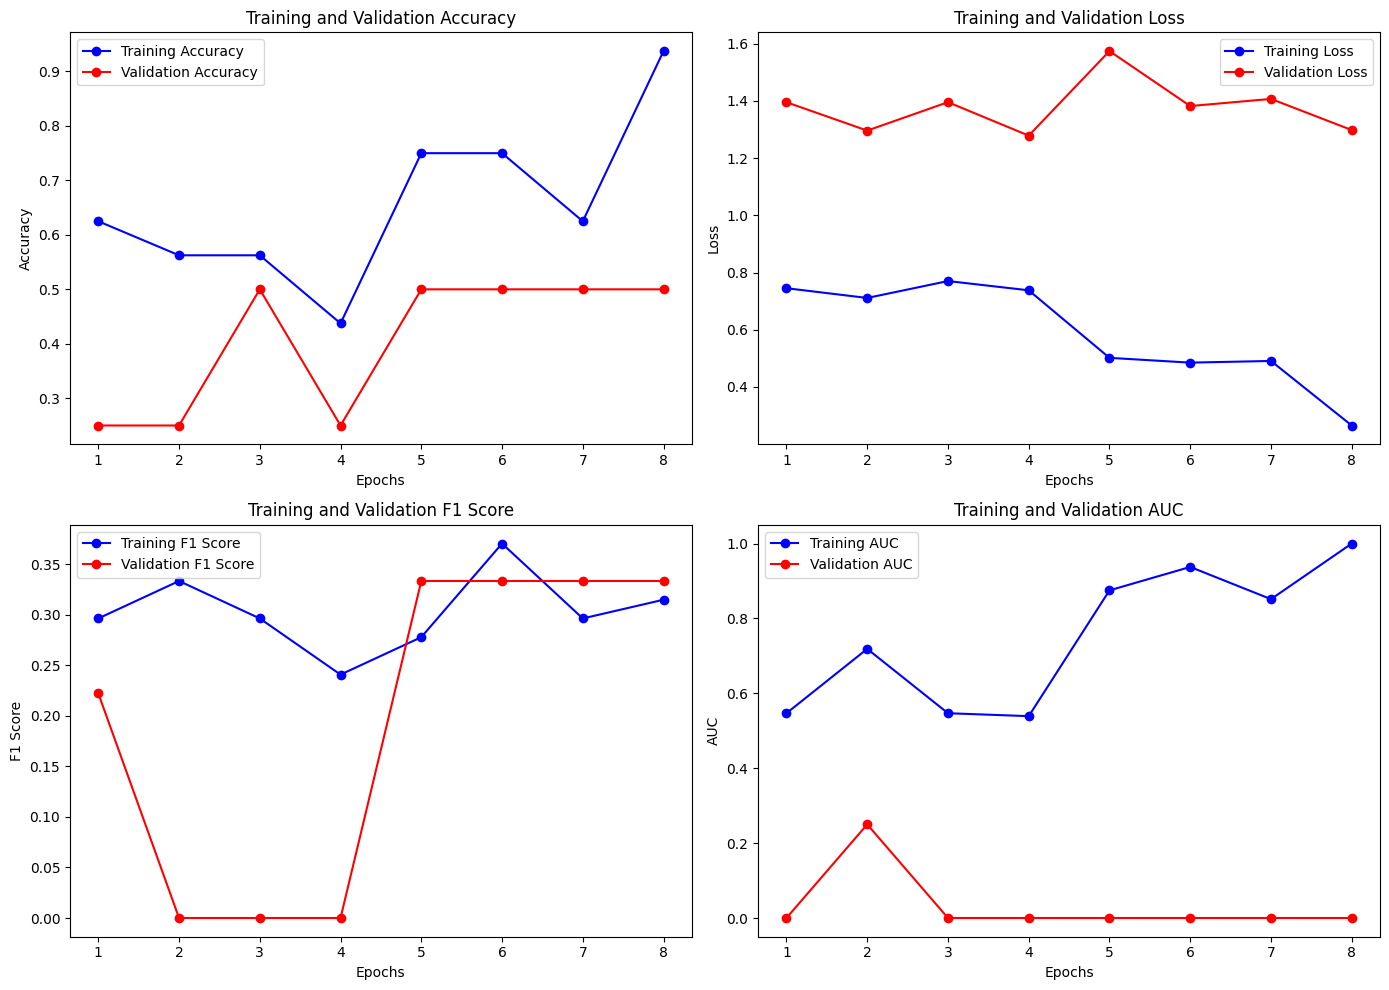

In [9]:
plot_metrics(history, "model_v3_metrics.png")